<a href="https://colab.research.google.com/github/cdwangco/SentimentAnalysisProject/blob/main/MLProjectYTSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import warnings
warnings.filterwarnings('ignore')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.stats.stats import RanksumsResult
# Evaluate the test using Flair baseline
from flair.models import TextClassifier
from flair.data import Sentence
from textblob import TextBlob
from sklearn.metrics import confusion_matrix, accuracy_score
import transformers as ppb
import matplotlib.pyplot as plt


In [44]:
#input data source here
df = pd.read_csv('data/train.tsv', delimiter='\t', header=None)

In [45]:
df.head()
df[1].value_counts() #we have a balanced data set
df = df[:2000]


In [46]:
analyzer = SentimentIntensityAnalyzer()

def getVader(text):
  score = analyzer.polarity_scores(text)
  return 1 if score['compound'] >= 0 else 0


In [47]:
df['Vader'] = df[0].apply(getVader)
df.head()

,0,1,Vader
0,"a stirring , funny and finally transporting re...",1,1
1,apparently reassembled from the cutting room f...,0,0
2,they presume their audience wo n't sit still f...,0,1
3,this is a visually stunning rumination on love...,1,1
4,jonathan parker 's bartleby should have been t...,1,1


In [48]:
classifier = TextClassifier.load('en-sentiment')

2022-12-02 12:41:14,538 loading file /Users/josegarza/.flair/models/sentiment-en-mix-distillbert_4.pt


In [49]:
def predict(sentence):
    """ Predict the sentiment of a sentence """
    if sentence == "":
        return 0
    text = Sentence(sentence)
    # stacked_embeddings.embed(text)
    classifier.predict(text)
    value = text.labels[0].to_dict()['value'] 
    return 0 if value == 'NEGATIVE' else 1

def flairPredict(sentence):
  result = predict(sentence)
  return result

In [50]:

df['FlairScore'] = df[0].apply(flairPredict)
df.head()
print(len(df))

KeyboardInterrupt: 

In [ ]:
def getSubj(text):
  return TextBlob(text).sentiment.subjectivity

def getPol(text):
  return TextBlob(text).sentiment.polarity

def binarize(float):
  return 1 if float > 0 else 0

In [ ]:

data = df.rename(columns={0: 'Comment', 1:'Label'})
data['Polarity'] = data['Comment'].apply(getPol)
data['TextBlob'] = data['Polarity'].apply(binarize)
data.head()

,Comment,Label,Vader,FlairScore,Polarity,TextBlob
0,"a stirring , funny and finally transporting re...",1,1,1,0.125000,1
1,apparently reassembled from the cutting room f...,0,0,0,-0.275000,0
2,they presume their audience wo n't sit still f...,0,1,0,0.178571,1
3,this is a visually stunning rumination on love...,1,1,1,0.500000,1
4,jonathan parker 's bartleby should have been t...,1,1,0,0.200000,1


In [ ]:
# Do BERT in parallel to compare baseline performance
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
tokenized = data['Comment'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
print(tokenized.head())

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

print(np.array(padded).shape)

attention_mask = np.where(padded != 0, 1, 0)
print(attention_mask.shape)


0    [101, 1037, 18385, 1010, 6057, 1998, 2633, 182...
1    [101, 4593, 2128, 27241, 23931, 2013, 1996, 62...
2    [101, 2027, 3653, 23545, 2037, 4378, 24185, 10...
3    [101, 2023, 2003, 1037, 17453, 14726, 19379, 1...
4    [101, 5655, 6262, 1005, 1055, 12075, 2571, 376...
Name: Comment, dtype: object
(2000, 59)
(2000, 59)


In [ ]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

features = last_hidden_states[0][:,0,:].numpy()

In [ ]:
print(input_ids.shape, 'and attention mask', attention_mask.shape)

torch.Size([2000, 59]) and attention mask torch.Size([2000, 59])


In [ ]:
lr_clf = LogisticRegression()
clf = lr_clf.fit(features,data['Label'])
data['Bert'] = clf.predict(features)
data.head()
print(lr_clf.score(features, data['Label']))

0.9085


In [ ]:
print('TextBlob Confusion Matrix')
print(confusion_matrix(data['Label'],data['TextBlob']))
textBlobAcc = accuracy_score(data['Label'],data['TextBlob'])
print('accuracy = ', textBlobAcc)

print('Vader Confusion Matrix')
print(confusion_matrix(data['Label'],data['Vader']))
vaderAcc = accuracy_score(data['Label'],data['Vader'])
print('accuracy = ',vaderAcc)

print('BERT Confusion Matrix')
print(confusion_matrix(data['Label'],data['Bert']))
bertAcc = accuracy_score(data['Label'],data['Bert'])
print('accuracy = ',bertAcc)

print('Flair Confusion Matrix')
print(confusion_matrix(data['Label'],data['FlairScore']))
flairAcc = accuracy_score(data['Label'],data['FlairScore'])
print('accuracy = ',flairAcc)

names = ['TextBlob','Vader', 'BERT', 'Flair']
accuracies = [textBlobAcc,vaderAcc, bertAcc, flairAcc]

TextBlob Confusion Matrix
[[571 388]
 [292 749]]
accuracy =  0.66
Vader Confusion Matrix
[[450 509]
 [154 887]]
accuracy =  0.6685
BERT Confusion Matrix
[[880  79]
 [104 937]]
accuracy =  0.9085
Flair Confusion Matrix
[[ 941   18]
 [  23 1018]]
accuracy =  0.9795


[0.66, 0.6685, 0.9085, 0.9795]


<BarContainer object of 4 artists>

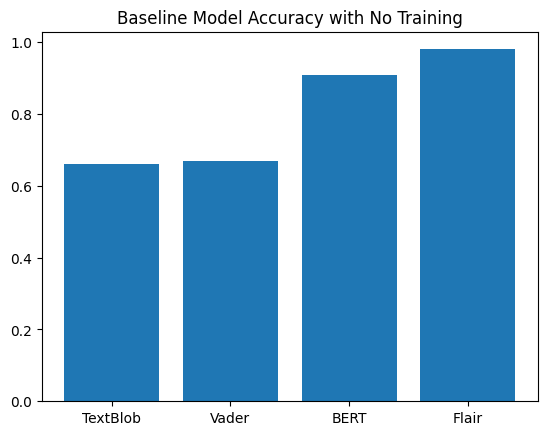

In [ ]:
plt.title('Baseline Model Accuracy with No Training')
print(accuracies)
plt.bar(names,accuracies)

In [52]:
score_to_text = {0:'BAD', 1:'GOOD'}

In [53]:
sentence = "I love the way you explained, plus the diversity :)"
max_len = 30
sentence_pred = flairPredict(sentence)
result = f'{score_to_text[sentence_pred]}: {sentence[:max_len]}...'
print(result)

sentence = "I hate the way you explained, plus no diversity"
sentence_pred = flairPredict(sentence)
result = f'{score_to_text[sentence_pred]}: {sentence[:max_len]}...'
print(result)

GOOD: I love the way you explained, ...
BAD: I hate the way you explained, ...
